Analiza podatkov tekmovanj EGMO
===============================

Najprej naložimo podatke iz `csv` datotek.

In [1]:
import pandas as pd

egmo_array = [pd.read_csv(f"podatki/csv/egmo{i}.csv") for i in range(2, 12)]

In [2]:
egmo = pd.concat(egmo_array, keys=[f"EGMO {i}" for i in range(2, 12)])
egmo[(egmo["code"].str.contains("SVN")) & (egmo["prize"] > 0)].sort_values(["prize", "name"], ascending=[False, True])

official  code              name  P1  P2  P3  P4  P5  P6  prize
EGMO 8  173      True  SVN2       Tea Jeličić   7   7   0   7   1   0      3
EGMO 6  144      True  SVN1  Ana Meta Dolinar   7   0   0   7   0   0      2
EGMO 7  171      True  SVN1  Ana Meta Dolinar   6   1   1   7   0   0      2
EGMO 8  172      True  SVN1  Ana Meta Dolinar   7   4   0   7   1   0      2
        174      True  SVN3        Ema Mlinar   7   0   0   7   3   1      2
EGMO 10 188      True  SVN1    Katarina Grilj   0   0   0   7   3   0      2
EGMO 11 195      True  SVN3    Katarina Grilj   7   5   0   3   0   0      2
EGMO 3  87       True  SVN2       Lara Jerman   0   1   0   0   7   0      2
EGMO 2  65       True  SVN3   Maruša Pečovnik   7   3   0   6   0   0      2
EGMO 7  173      True  SVN3        Ana Opalič   7   0   1   2   0   0      1
EGMO 11 196      True  SVN4       Kaja Rajter   7   0   0   7   0   0      1
EGMO 6  145      True  SVN2    Klara Drofenik   7   0   0   0   2   0      1
EGMO 4  89       True  SVN3       Klara Nosan   1   2   0   7   0   0      1
EGMO 2  63       True  SVN1       Lara Jerman   7   4   0   2   0   0      1
        66       True  SVN4    Mihaela Pušnik   7   2   0   2   2   0      1
EGMO 11 194      True  SVN2     Nives Gošnjak   7   0   0   1   4   0      1
EGMO 4  90       True  SVN4    Timeja Strašek   7   0   0   0   0   0      1
EGMO 7  174      True  SVN4       Špela Polak   7   1   0   2   0   0      1
EGMO 8  175      True  SVN4       Špela Polak   4   0   0   7   1   0      1

Za ogled rezultatov drugih držav je potrebno kratico "SVN" v zgornji kodi zamenjati s primerno kratico države. Te so dostopne na [uradni strani tekmovanja](https://www.egmo.org/countries/).

Oglejmo si še porazdelitev točk vseh sodelujočih tekmovalk letošnje izvedbe tekmovanja:

<AxesSubplot:>

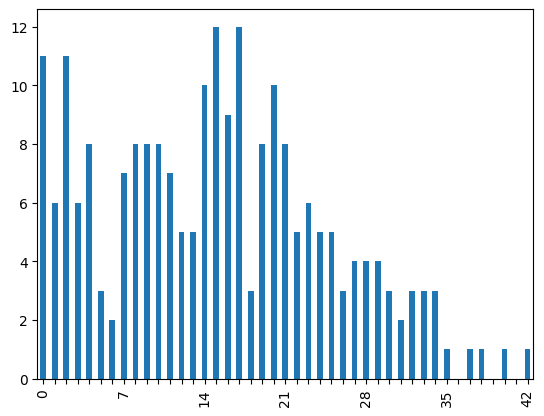

In [3]:
egmo11 = pd.read_csv("podatki/csv/egmo11.csv")
egmo11['skupaj'] = sum(egmo11[f"P{i}"] for i in range(1,7))
graf = egmo11['skupaj'].value_counts().reindex(index=[t for t in range(43)]).sort_index().plot.bar(x='skupaj', y='count')
for i, t in enumerate(graf.get_xticklabels()):
    if (i % 7) != 0:
        t.set_visible(False)
graf

Ogledamo si lahko tudi samo porazdelitev točk pri določeni nalogi:

<AxesSubplot:>

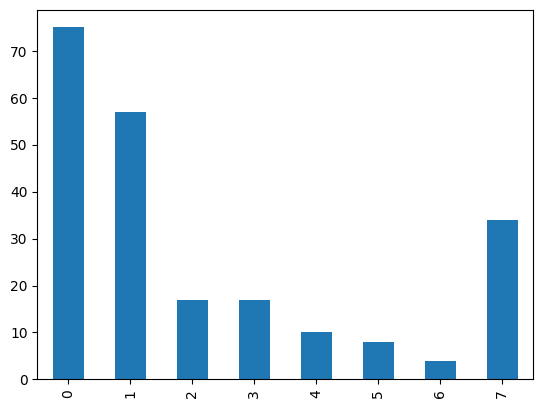

In [4]:
graf = egmo11['P5'].value_counts().reindex(index=[t for t in range(8)]).sort_index().plot.bar(x='2. naloga', y='count')
graf

Za konec si oglejmo še ekipne rezultate, posebej, slovenske uvrstitve na vseh izvedbah od druge dalje. V spodnjem grafu je uvrstitev držav **obrnjena** - višja točka na grafu pomeni boljšo uvrstitev.

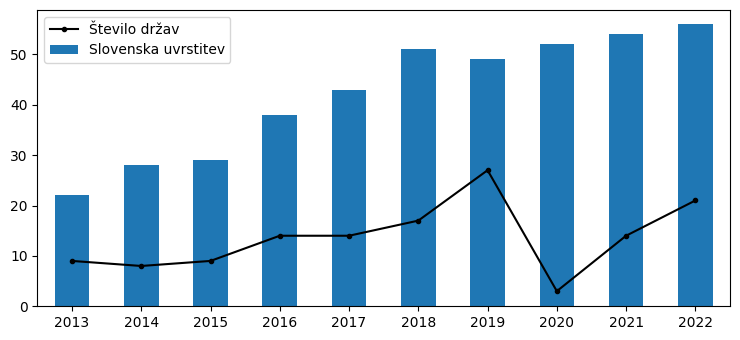

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
number_of_countries = []
placement = []
for i in range(2, 12):
    current_egmo = pd.read_csv(f"podatki/csv/egmo{i}.csv")
    current_egmo['code'] = current_egmo['code'].str[:3]
    by_countries = current_egmo.groupby(['code']).sum()
    by_countries['total'] = by_countries.iloc[:,1:7].sum(axis=1)
    by_countries = by_countries.sort_values(['total'], ascending=False)
    number_of_countries.append(len(by_countries))
    try:
        placement.append(len(by_countries) - by_countries.index.get_loc("SVN"))
    except KeyError:
        placement.append(None)
countries = pd.DataFrame(number_of_countries)
slovenia = pd.DataFrame(placement)
fig, ax = plt.subplots()
countries.plot(kind="bar", ax=ax, label='Število držav')
slovenia.plot(kind="line", color="black", ax=ax, style='.-', label='Slovenska uvrstitev')
ax.legend(["Število držav", "Slovenska uvrstitev"])
ax.set_xticklabels(range(2013, 2013 + len(countries)))
plt.show()

Napovedovalec rezultatov
------------------------

Po tekmovanju vsako leto pride na vrsto nestrpno čakanje rezultatov in mej za medalje. Kaj pa, če smo zelo neučakani in nas te zanimajo preden so znani rezultati? Iz nepopolnih podatkov o tekmovanju bomo poskusili napovedati meje za medalje. Koda za napovedovalca je malo daljša, zato se nahaja v datoteki `predictor.py`, ki jo tu preprosto "importamo".

<AxesSubplot:xlabel='idx'>

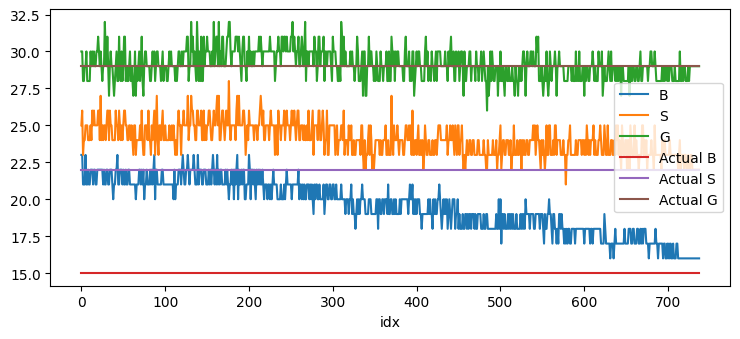

In [6]:
import predictor

predictor.main(11, fq=False, cond="random").plot.line()

Zgornji napovedovalec deluje tako, da vse neznane rezultate dopolnimo naključno, in sicer enakomerno izberemo naravno število z intervala [0, 7]. Zaradi naključnega izbiranja je zgornji graf precej "divji". Poleg tega razporeditev točk še zdaleč ni enakomerna, o čemer smo se lahko prepričali zgoraj. Poskusimo najprej popraviti porazdelitev tako, da upoštevamo že poznane točke in pa porazdelitev točk prejšnjega leta.

<AxesSubplot:xlabel='idx'>

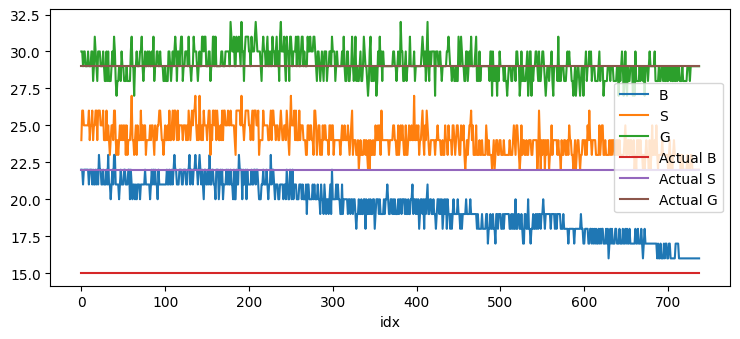

In [7]:
predictor.main(11, cond="random").plot.line()

Vseeno ne vidimo bistvenega izboljšanja. Pridobljene točke po posameznih nalogah namreč niso neodvisne - boljša tekmovalka bo verjetno pri več nalogah dobila veliko število točk. Zadnji napovedovalec upošteva še to - najprej izračuna povprečno uvrstitev določene države, nato pa tekmovalkam iz statistično močnejših držav da več točk kot tistim iz slabših.

<AxesSubplot:xlabel='idx'>

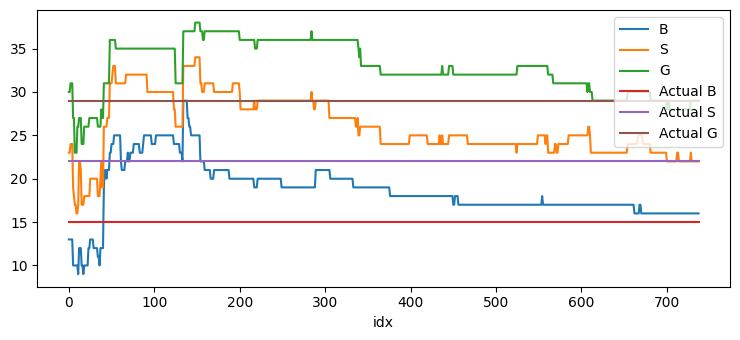

In [8]:
predictor.main(11).plot.line()

To je že bistveno bolje. Ni več naključnega skakanja, saj sedaj točke razdelimo deterministično, poleg tega pa napovedi opazno hitreje konvergirajo k dejanskim vrednostim.

Seveda pa koristi imeti kakšno gotovo informacijo. S tem namenom preverimo še spreminjanje minimalnih in maksimalnih mej za medalje s časom.

<AxesSubplot:xlabel='idx'>

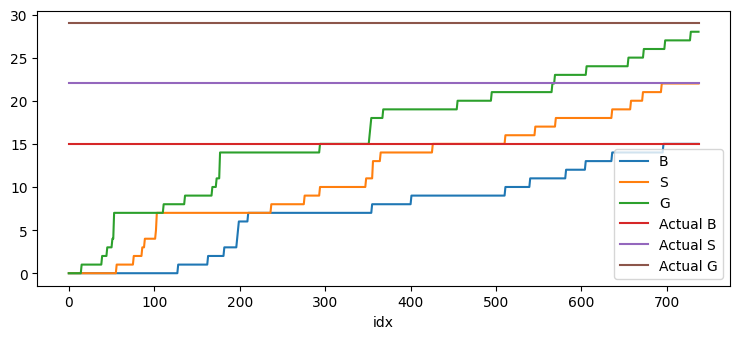

In [9]:
predictor.main(11, cond="min").plot.line()

<AxesSubplot:xlabel='idx'>

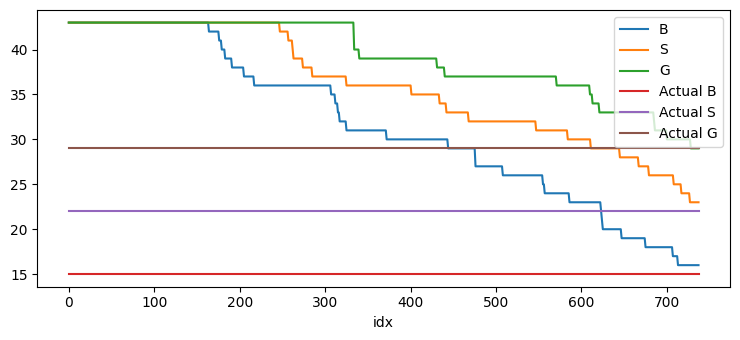

In [10]:
predictor.main(11, cond="max").plot.line()